# ml lab1

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

DATA_URL = 'https://commondatastorage.googleapis.com/books1000/notMNIST_small.tar.gz'
DATA_DIR = 'data'

### 1.1 fetch data

In [2]:
import requests
import humanize
import tarfile

filename = os.path.basename(DATA_URL)
filepath = f'{DATA_DIR}/{filename}'

print(f'path:\t{filepath}')

def fetch():
    if os.path.exists(filepath):
        return
    r = requests.get(DATA_URL)
    size = r.headers.get('content-length', 0)
    print(f'size:\t{humanize.naturalsize(size)}')
    
    os.makedirs(DATA_DIR, exist_ok=True)

    with open(filepath, 'wb') as f:
        f.write(r.content)


def parse():
    tar = tarfile.open(filepath)
    members = tar.getmembers()
    print(f'files:\t{len(members)}')
    sub_folder = members[0].name
    tar.extractall(DATA_DIR)
    tar.close()
    return f'{DATA_DIR}/{sub_folder}'
    
fetch()
data_path = parse()

path:	data/notMNIST_small.tar.gz
size:	8.5 MB
files:	18737


### 1.2 plot data

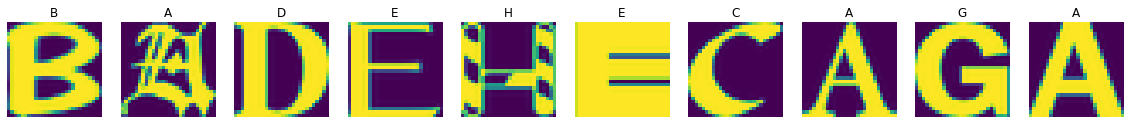

In [3]:
import random

letters = sorted(os.listdir(data_path))
fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for ax in axs:
    l = random.choice(letters)
    l_dir = f'{data_path}/{l}'
    image = random.choice(os.listdir(l_dir))
    ax.imshow(plt.imread(f'{l_dir}/{image}'))
    ax.set_title(l)
    ax.axis('off')

### 2. check dataset balance

In [4]:
stats = dict()

for l in letters:
    l_dir = f'{data_path}/{l}'
    stats[l] = len(os.listdir(l_dir))
    
total = sum(stats.values())
print(f'total: {total}')
print(f'balanced: {total / len(letters)}')
print('real:')
stats

total: 18726
balanced: 1872.6
real:


{'A': 1873,
 'B': 1873,
 'C': 1873,
 'D': 1873,
 'E': 1873,
 'F': 1873,
 'G': 1872,
 'H': 1872,
 'I': 1872,
 'J': 1872}

### 3-4. train / test samples + data cleaning

In [13]:
import hashlib

image_width = 28

X = np.zeros((total, image_width, image_width))
y = np.zeros((total))
i = 0

hashes = set()

for l_id, letter in enumerate(letters):
    l_dir = f'{data_path}/{letter}'
    for image in os.listdir(l_dir):
        try:
            img = plt.imread(f'{l_dir}/{image}')
            img_hash = hashlib.sha256(img).hexdigest()
            if img_hash in hashes:
                continue
            hashes.add(img_hash)
            X[i, :, :] = img
            y[i] = l_id
            i += 1
        except:
            continue

In [42]:
duplicates = (total - i) / total * 100
print(f'duplicates:\t{duplicates:.2f}%')

# fit in new size
y = y[:i]
X = X[:i]

X.shape, y.size

duplicates:	2.64%


((18232, 28, 28), 18232)

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.7)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, train_size=0.7)

samples_size = [y_train.size, y_test.size, y_val.size]
samples_size, sum(samples_size)

([12762, 3828, 1642], 18232)

###  5. build classifier

In [90]:
%%capture --no-stdout

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def get_score(_clf, X, y):
    predict = _clf.predict(X.reshape(X.shape[0], -1))
    return accuracy_score(predict, y)    

clf = LogisticRegression(random_state=42, max_iter=1500)

train_total = len(X_train)
runs = 5
step = train_total // runs

test_scores = []
val_scores = []
sizes = range(step, train_total, step)
for size in sizes:
    idx = np.random.randint(0, train_total, size)
    X = X_train[idx, :, :].reshape(-1, X_train.shape[1] * X_train.shape[2])
    y = y_train[idx]
    
    clf.fit(X, y)
    test_score = get_score(clf, X_test, y_test)
    test_scores.append(test_score)
    val_scores.append(get_score(clf, X_val, y_val))
    
    print(f'> {size}: {test_score * 100:.3f}%')

> 2552: 86.181%
> 5104: 86.677%
> 7656: 87.330%
> 10208: 86.808%
> 12760: 86.729%


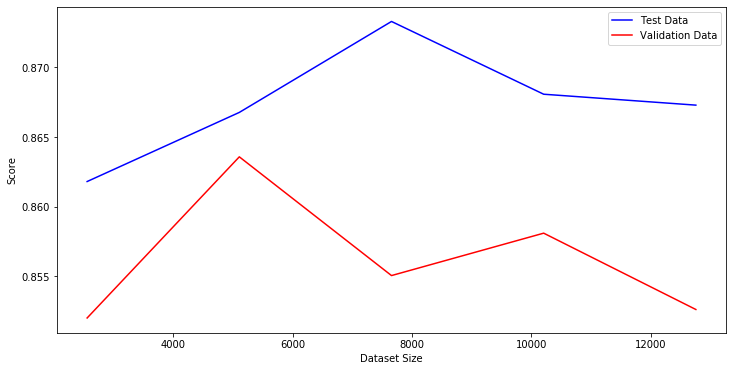

In [92]:
plt.figure(figsize=(12, 6))
plt.plot(sizes, test_scores, 'b', label='Test Data')
plt.plot(sizes, val_scores, 'r', label='Validation Data')
plt.xlabel('Dataset Size')
plt.ylabel('Score')
plt.legend()
plt.show()